 ## Analyses de la pollution sur la base de données exploitable (gender gap et pollution disponible)

In [102]:
# Documentation de la base de données disponible ici : https://challengedata.ens.fr/challenges/87 

#Discrimination puisse se faire également par l’obtention du job ? Gender gap qui mesure 
#de façon brut les différences entres hommes et femmes au sein de l’entreprise sans contrôler
#des différences de niveau de formation, d’âge

#Stats ?? :
# o	OCDE -> taux de féminisation
# o	Eurostat -> taux de féminisation par secteur, par pays

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statistics import mode
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

pd.options.mode.chained_assignment = None


file_raw_path = "data/ESG_raw_data_07_02.xlsx"
data = pd.read_excel(file_raw_path)

In [103]:
pd.set_option('display.max_columns', 50)
data.head()
len(set(data['primary_industry']))

154

In [104]:
data['scope_1_per_capita'] = data['scope_1'] / data['employees']
data['scope_2_per_capita'] = data['scope_2'] / data['employees']
data['scope_3_per_capita'] = data['scope_3'] / data['employees']
data['scope_per_capita'] = data['scope_1_per_capita'] + data['scope_2_per_capita'] + data['scope_3_per_capita']

# Filter out rows with non-NA values for 'gender_pay_gap', 'scope_1', 'scope_2', and 'scope_3'
filtered_data = data.dropna(subset=['gender_pay_gap', 'scope_1', 'scope_2', 'scope_3'])
filter1 = data.dropna(subset=['gender_pay_gap', 'scope_2', 'scope_3'])
filter2 = data.dropna(subset=['gender_pay_gap', 'scope_1', 'scope_3'])
filter3 = data.dropna(subset=['gender_pay_gap', 'scope_1', 'scope_2'])
filter4 = data.dropna(subset=['scope_1', 'scope_2', 'scope_3'])
filter5 = data.dropna(subset=['gender_pay_gap'])

print("0."+str(len(filtered_data)))
print("1."+str(len(filter1)))
print("2."+str(len(filter2)))
print("3."+str(len(filter3)))
print("4."+str(len(filter4)))
print("5."+str(len(filter5)))

print(filtered_data.reset_index())

original_data_by_region = data.groupby('region').size()
filtered_data_by_region = filtered_data.groupby('region').size()
filtered_data_by_year = filtered_data.groupby('year').size()
filtered_data_by_industry = filtered_data.groupby('primary_industry').size()

# Calculate attrition rate
attrition_rate_by_region = (1 - filtered_data_by_region / original_data_by_region) * 100

# Print the results
print("Original data size by region:")
print(original_data_by_region)
print("\nFiltered data size by region:")
print(filtered_data_by_region)
print("\nFiltered data size by year:")
print(filtered_data_by_year)
print("\nTop 10 Industries by size:")
print(filtered_data_by_industry.head(10))
print("\nAttrition rate by region (%):")
print(attrition_rate_by_region)

# Construct variables for scope 1, scope 2, and scope 3 emissions per capita
#filtered_data['scope_1_per_capita'] = filtered_data['scope_1'] / filtered_data['employees']
#filtered_data['scope_2_per_capita'] = filtered_data['scope_2'] / filtered_data['employees']
#filtered_data['scope_3_per_capita'] = filtered_data['scope_3'] / filtered_data['employees']
#filtered_data['scope_per_capita'] = filtered_data['scope_1_per_capita'] + filtered_data['scope_2_per_capita'] + filtered_data['scope_3_per_capita']


0.286
1.290
2.288
3.366
4.9745
5.405
     index                            company_id  year  \
0       42  116a59e2-5659-4f61-a47f-18a17195871d  2020   
1       57  1400c037-3aac-4f4a-8c4a-ea60eae061a1  2020   
2       58  1400c037-3aac-4f4a-8c4a-ea60eae061a1  2019   
3       59  1400c037-3aac-4f4a-8c4a-ea60eae061a1  2018   
4       60  64f46ddd-0d99-41a9-8248-23d0ff552bc5  2020   
..     ...                                   ...   ...   
281  34677  797eb441-1ca6-4325-aaa3-70f39636adce  2020   
282  35151  4d5a4506-47fa-4c8a-aed7-36b1524efe86  2020   
283  37071  cd534e47-b0da-4bfa-a179-24e4191a3640  2020   
284  37725  96cfccca-6c54-45cd-a124-5b6f4c3d652a  2020   
285  40410  f644cbde-c426-4557-a242-04929d089550  2020   

                         company_name         ticker                   LEI  \
0                  NVIDIA Corporation  NasdaqGS:NVDA  549300S4KLFTLO7GSQ80   
1             Mastercard Incorporated        NYSE:MA  AR5L2ODV9HN37376R084   
2             Mastercard Incorpo

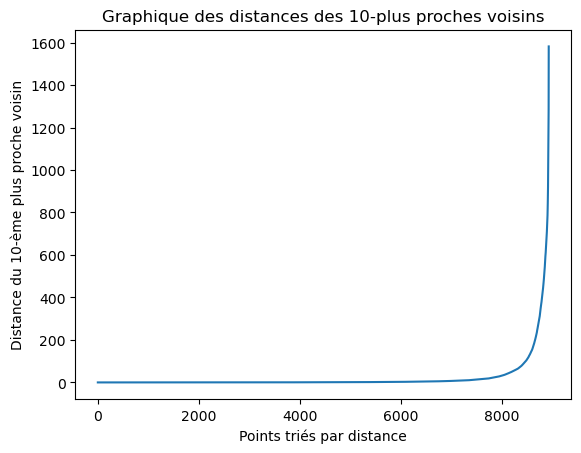

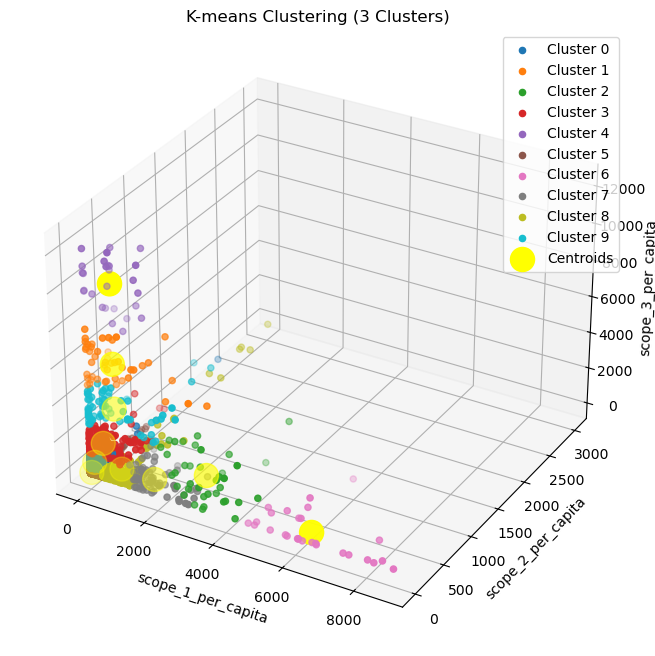

Tires and Rubber
cluster
5    13
3     6
0     6
Name: count, dtype: int64
Trucking
cluster
5    54
1     1
0     1
Name: count, dtype: int64
Gas Utilities
cluster
5    30
0    15
8     5
9     4
4     3
1     2
3     2
Name: count, dtype: int64
Renewable Electricity
cluster
5    25
8     9
3     3
7     2
2     1
Name: count, dtype: int64
Oil and Gas Drilling
cluster
5    6
Name: count, dtype: int64
Department Stores
cluster
5    29
0     1
9     1
Name: count, dtype: int64
Multi-Sector Holdings
cluster
5    6
8    1
2    1
Name: count, dtype: int64
Soft Drinks
cluster
5    31
0     1
Name: count, dtype: int64
Homefurnishing Retail
cluster
5    11
Name: count, dtype: int64
Packaged Foods and Meats
cluster
5    210
0     26
3      1
Name: count, dtype: int64
IT Consulting and Other Services
cluster
5    118
0      3
4      2
6      2
Name: count, dtype: int64
Managed Health Care
cluster
5    13
Name: count, dtype: int64
Regional Banks
cluster
5    261
0      3
Name: count, dtype: int64

In [109]:
from sklearn.utils import resample
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
clust = data[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita','primary_industry']]
clust.dropna(inplace=True)

# Sélectionner les variables pour le clustering
X = clust[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita']]

# Calculer la distance des k-plus proches voisins
k = 10  # Nombre de voisins à considérer, vous pouvez ajuster selon votre cas
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, _ = nbrs.kneighbors(X)

# Exécuter DBSCAN pour étiqueter les points en clusters
dbscan = DBSCAN(eps=1000, min_samples=5)  # Réglez eps et min_samples selon votre cas
clusters = dbscan.fit_predict(X)

# Identifier les points étiquetés comme du bruit (noise)
noise_indices = dbscan.labels_ == -1

# Supprimer les points étiquetés comme du bruit de la base de données
clust = clust[~noise_indices]
X = clust[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita']]

# Calculer la distance des k-plus proches voisins
k = 10  # Nombre de voisins à considérer, vous pouvez ajuster selon votre cas
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, _ = nbrs.kneighbors(X)

# Trier les distances pour chaque point
sorted_distances = np.sort(distances, axis=0)
mean_distances = np.mean(sorted_distances, axis=1)

# Tracer le graphique des distances des k-plus proches voisins
plt.plot(np.arange(1, len(mean_distances) + 1), mean_distances)
plt.xlabel('Points triés par distance')
plt.ylabel('Distance du {}-ème plus proche voisin'.format(k))
plt.title('Graphique des distances des {}-plus proches voisins'.format(k))
plt.show()

# Créer le modèle KMeans
kmeans = KMeans(n_clusters=10, random_state=42)  # Choix arbitraire de 3 clusters

# Adapter le modèle aux données
kmeans.fit(X)

# Obtenir les étiquettes de cluster pour chaque point de données
labels = kmeans.labels_

# Ajouter les étiquettes de cluster au dataframe
clust['cluster'] = labels

# Représentation en 3D des clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Afficher chaque cluster avec une couleur différente
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for label, color in zip(range(len(kmeans.cluster_centers_)), colors):
    ax.scatter(clust[clust['cluster'] == label]['scope_1_per_capita'], 
               clust[clust['cluster'] == label]['scope_2_per_capita'], 
               clust[clust['cluster'] == label]['scope_3_per_capita'], 
               c=color, label='Cluster ' + str(label))

# Marquer les centres de cluster
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], 
           s=300, c='yellow', label='Centroids', marker='o')

ax.set_xlabel('scope_1_per_capita')
ax.set_ylabel('scope_2_per_capita')
ax.set_zlabel('scope_3_per_capita')
ax.set_title('K-means Clustering (3 Clusters)')

plt.legend()
plt.show()

indus = set(data['primary_industry'])
for i in indus:
    print(i)
    print(clust[clust['primary_industry']==i]['cluster'].value_counts())

In [77]:
print(cluster_sizes)

cluster
0    9027
1       8
2       4
Name: count, dtype: int64


In [75]:
# Au vu du nombre de données disponibles sur le gender pay gap, il semble uniquement possible
# d'étudier l'europe et les US/Canada sur la question du lien entre pollution - gender pay gap


# Filter data for Europe and United States and Canada
europe_data = filtered_data[filtered_data['region'] == 'Europe']
us_canada_data = filtered_data[filtered_data['region'] == 'United States and Canada']

# Calculate the mean of scopes for Europe grouped by year
europe_mean_scopes_by_year = europe_data.groupby('year')[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita', 'scope_per_capita']].mean()

# Calculate the mean of scopes for US/Canada grouped by year
us_canada_mean_scopes_by_year = us_canada_data.groupby('year')[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita', 'scope_per_capita']].mean()

print("\n Average pollution in Europe by scope and year:")
print(europe_mean_scopes_by_year)
print("\n Average pollution in United States and Canada by scope and year:")
print(us_canada_mean_scopes_by_year)

# A première vue, on a l'impression que la pollution est bien plus elevée en Europe que United States and Canada
# mais cela cache surement de grandes différences sectorielles


 Average pollution in Europe by scope and year:
      scope_1_per_capita  scope_2_per_capita  scope_3_per_capita  \
year                                                               
2018          341.917413           28.735286          918.785385   
2019          222.491803           22.422206          857.710565   
2020          111.690900           39.494208          379.828838   

      scope_per_capita  
year                    
2018       1289.438084  
2019       1102.624575  
2020        531.013947  

 Average pollution in United States and Canada by scope and year:
      scope_1_per_capita  scope_2_per_capita  scope_3_per_capita  \
year                                                               
2018            0.317669            0.723057            7.708699   
2019            0.198842            0.407529            4.171400   
2020           10.033159            2.128784            7.951682   

      scope_per_capita  
year                    
2018          8.749425  
20

In [76]:
# Count the occurrences of each industry for Europe and US/Canada
europe_industry_counts = europe_data['primary_industry'].value_counts()
us_canada_industry_counts = us_canada_data['primary_industry'].value_counts()

# Sort the industries based on the number of observations
europe_sorted_industries = europe_industry_counts.sort_values(ascending=False)
us_canada_sorted_industries = us_canada_industry_counts.sort_values(ascending=False)

# Print only the first 10 elements of each sorted list
print("Top 10 Industries in Europe by Number of Observations:")
print(europe_sorted_industries.head(10))
print("\nTop 10 Industries in US/Canada by Number of Observations:")
print(us_canada_sorted_industries.head(10))


# Filter data for the industry "Data Processing and Outsourced Services" in Europe and US/Canada
europe_data_dpos = europe_data[europe_data['primary_industry'] == 'Data Processing and Outsourced Services']
us_canada_data_dpos = us_canada_data[us_canada_data['primary_industry'] == 'Data Processing and Outsourced Services']

# Calculate the average scope 1, 2, and 3 emissions for the industry in Europe per year
europe_avg_scopes_dpos_by_year = europe_data_dpos.groupby('year')[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita', 'scope_per_capita']].mean()

# Calculate the average scope 1, 2, and 3 emissions for the industry in US/Canada per year
us_canada_avg_scopes_dpos_by_year = us_canada_data_dpos.groupby('year')[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita', 'scope_per_capita']].mean()

# Print the results
print("Average Scope 1, 2, and 3 Emissions for 'Data Processing and Outsourced Services' Industry per Year:")
print("Europe:")
print(europe_avg_scopes_dpos_by_year)
print("\nUS/Canada:")
print(us_canada_avg_scopes_dpos_by_year)

# Si on regarde dans un secteur précis, la tendance précédente s'inverse et on a maintenant une pollution moyenne plus elevée
# aux United States and Canada

# Difficultés à comparer au vu du nombre très réduit d'observations ( - de 2 par an dans le secteur sur la région
# US and Canada

Top 10 Industries in Europe by Number of Observations:
primary_industry
Electric Utilities                         16
Integrated Telecommunication Services      11
Data Processing and Outsourced Services    11
Homebuilding                               10
Multi-line Insurance                        9
Real Estate Operating Companies             8
Specialty Chemicals                         8
Food Retail                                 8
Research and Consulting Services            8
Life and Health Insurance                   7
Name: count, dtype: int64

Top 10 Industries in US/Canada by Number of Observations:
primary_industry
Data Processing and Outsourced Services    4
Systems Software                           4
Automobile Manufacturers                   3
Specialty Chemicals                        3
Property and Casualty Insurance            3
Multi-Utilities                            3
Tobacco                                    2
Soft Drinks                                1
Financ

In [45]:
europe_data_specialty_chem[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita', 'company_name', 'year']]

,scope_1_per_capita,scope_2_per_capita,scope_3_per_capita,company_name,year
1626,6.194928,2.175877,118.429283,Givaudan SA,2020
1627,6.890707,3.435700,122.116908,Givaudan SA,2019
1628,8.000956,4.048537,135.561038,Givaudan SA,2018
4053,26.323188,13.017945,173.270760,Croda International Plc,2020
6540,34.385470,36.148827,370.305061,Clariant AG,2020
6541,33.498032,38.522737,400.301482,Clariant AG,2019
6542,24.021004,28.490028,284.900285,Clariant AG,2018
16380,20.870709,10.540046,1.844394,Victrex plc,2020


In [50]:
us_canada_data_specialty_chem[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita', 'company_name', 'year']]


,scope_1_per_capita,scope_2_per_capita,scope_3_per_capita,company_name,year
891,0.006431,0.003287,0.156963,Ecolab Inc.,2020
892,0.008192,0.004350,0.139955,Ecolab Inc.,2019
893,0.008350,0.005199,0.140946,Ecolab Inc.,2018


In [48]:
us_canada_data_dpos[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita', 'company_name', 'year']]


,scope_1_per_capita,scope_2_per_capita,scope_3_per_capita,company_name,year
57,0.153381,2.501810,17.435381,Mastercard Incorporated,2020
58,0.255806,2.803280,27.043656,Mastercard Incorporated,2019
59,0.326216,3.571554,33.510946,Mastercard Incorporated,2018
6954,0.297909,1.618636,6.668364,The Western Union Company,2020


In [82]:
# Comparer la contribution de chaque scope dans la somme en fonction des secteurs

filtered_industry_counts = filtered_data['primary_industry'].value_counts()
filtered_industry_counts = filtered_industry_counts.sort_values(ascending=False)


# Scope 1 covers emissions from sources that an organisation owns or controls directly
# – for example from burning fuel in our fleet of vehicles (if they’re not electrically-powered).

# Scope 2 are emissions that a company causes indirectly and come from where the energy
# it purchases and uses is produced. For example, the emissions caused when generating
# the electricity that we use in our buildings would fall into this category.

# Scope 3 encompasses emissions that are not produced by the company itself and are not
# the result of activities from assets owned or controlled by them,
# but by those that it’s indirectly responsible for up and down its value chain.
# An example of this is when we buy, use and dispose of products from suppliers.
# Scope 3 emissions include all sources not within the scope 1 and 2 boundaries.

# I would say that Electric Utilities have scope_1_per_capita / scope_2_per_capita  >>>> than
# Data Processing and Outsourced Services 

# Print only the first 10 elements of each sorted list
print("Top 10 Industries in Europe by Number of Observations:")
print(filtered_industry_counts.head(10))

# Filter data for the industry "Data Processing and Outsourced Services"
data_dpos = filtered_data[filtered_data['primary_industry'] == 'Data Processing and Outsourced Services']

# Calculate the average scope 1, 2, and 3 emissions for the industry "Data Processing and Outsourced Services" per year
avg_scopes_dpos_by_year = data_dpos.groupby('year')[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita', 'scope_per_capita']].mean()

# Print the results
print("Average Scope 1, 2, and 3 Emissions for 'Data Processing and Outsourced Services' Industry per Year:")
print(avg_scopes_dpos_by_year)

# Filter data for the industry "Electric Utilities"
data_electric_utilities = filtered_data[filtered_data['primary_industry'] == 'Electric Utilities']

# Calculate the average scope 1, 2, and 3 emissions for the industry "Electric Utilities" per year
avg_scopes_electric_utilities_by_year = data_electric_utilities.groupby('year')[['scope_1_per_capita', 'scope_2_per_capita', 'scope_3_per_capita', 'scope_per_capita']].mean()

# Print the results
print("\nAverage Scope 1, 2, and 3 Emissions for 'Electric Utilities' Industry per Year:")
print(avg_scopes_electric_utilities_by_year)

# Comme attendu, on retrouve bien une consommation beaucoup plus importante sur tous les scopes
# dans le secteur 'Electric Utilities' ( ordre de grandeur 10^3 vs 10^1)

# On observe également une baisse de la polution moyenne dans les 2 secteurs entre 2019/2020 vs 2018
# qui est surement liée à la baisse d'activité liée au COVID-19 ces années là

# On peut calculer le Coefficient of variation (CV) pour comparer la relative dispersion de la pollution
# dans les deux secteurs par année

def coefficient_of_variation(data):
    return data.std() / data.mean() * 100

cv_dpos_by_year = data_dpos.groupby('year')[[ 'scope_per_capita']].apply(coefficient_of_variation)
cv_electric_utilities_by_year = data_electric_utilities.groupby('year')[[ 'scope_per_capita']].apply(coefficient_of_variation)

print("\nCoefficient of Variation (CV) for Data Processing and Outsourced Services by Year:")
print(cv_dpos_by_year)

print("\nCoefficient of Variation (CV) for Electric Utilities by Year:")
print(cv_electric_utilities_by_year)

# On retrouve des CV du même ordre de grandeur dans les deux secteurs avec une augmentation de la dispersion en 2020

Top 10 Industries in Europe by Number of Observations:
primary_industry
Electric Utilities                         19
Data Processing and Outsourced Services    15
Integrated Telecommunication Services      12
Specialty Chemicals                        11
Homebuilding                               11
Multi-line Insurance                        9
Real Estate Operating Companies             9
Property and Casualty Insurance             9
Food Retail                                 8
Research and Consulting Services            8
Name: count, dtype: int64
Average Scope 1, 2, and 3 Emissions for 'Data Processing and Outsourced Services' Industry per Year:
      scope_1_per_capita  scope_2_per_capita  scope_3_per_capita  \
year                                                               
2018            0.351655            1.507844           26.593631   
2019            0.362623            1.391432           17.862719   
2020            0.226558            1.400365            6.402073   

